### Tokenizer fertility analysis for file filtering

* we will run the tokenizer trained on data (after filtering + PII redaction) to get fertility on the-stack-smol dataset
* we will also test the same tokenizer on the data it was trained on to see if there's a diffrence in the threshold and percentage of data filtered (the-stack-pjjs-pii-filtered)
* we will test a similar tokenizer trained on data before filtering and PII redactionto see if it detects those files with a high number of keys in PII redaction

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
from matplotlib import pyplot as plt
import numpy as np

In [2]:
ds_python = load_dataset('bigcode/the-stack-smol', data_dir="data/python", split="train")
ds_java = load_dataset('bigcode/the-stack-smol', data_dir="data/java", split="train")
ds_js = load_dataset('bigcode/the-stack-smol', data_dir="data/javascript", split="train")

Using custom data configuration bigcode--the-stack-smol-7b51f8bde3058781
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration bigcode--the-stack-smol-95a2b7de57a7cb35
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-95a2b7de57a7cb35/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration bigcode--the-stack-smol-848a30ee7bac5c92
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-848a30ee7bac5c92/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


In [3]:
ds_python_filter = load_dataset('bigcode/stack-pjjs-pii-filtered-smol', data_dir="data/python", split="train", use_auth_token=True)
ds_java_filter = load_dataset('bigcode/stack-pjjs-pii-filtered-smol', data_dir="data/java", split="train", use_auth_token=True)
ds_js_filter = load_dataset('bigcode/stack-pjjs-pii-filtered-smol', data_dir="data/javascript", split="train", use_auth_token=True)

Using custom data configuration bigcode--stack-pjjs-pii-filtered-smol-6782f925a3950d03
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--stack-pjjs-pii-filtered-smol-6782f925a3950d03/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration bigcode--stack-pjjs-pii-filtered-smol-daa80c903c8b7f58
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--stack-pjjs-pii-filtered-smol-daa80c903c8b7f58/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration bigcode--stack-pjjs-pii-filtered-smol-5322d73266feb990
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--stack-pjjs-pii-filtered-smol-5322d73266feb990/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


In [44]:
ds_python_filter

Dataset({
    features: ['hexsha', 'size', 'ext', 'lang', 'max_stars_repo_path', 'max_stars_repo_name', 'max_stars_repo_head_hexsha', 'max_stars_repo_licenses', 'max_stars_count', 'max_stars_repo_stars_event_min_datetime', 'max_stars_repo_stars_event_max_datetime', 'max_issues_repo_path', 'max_issues_repo_name', 'max_issues_repo_head_hexsha', 'max_issues_repo_licenses', 'max_issues_count', 'max_issues_repo_issues_event_min_datetime', 'max_issues_repo_issues_event_max_datetime', 'max_forks_repo_path', 'max_forks_repo_name', 'max_forks_repo_head_hexsha', 'max_forks_repo_licenses', 'max_forks_count', 'max_forks_repo_forks_event_min_datetime', 'max_forks_repo_forks_event_max_datetime', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'index', 'content'],
    num_rows: 10000
})

In [7]:
#tokenizer = AutoTokenizer.from_pretrained("bigcode/tokenizer", subfolder="digit-bytelevel-bpe-py-js-java-49k")

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bigcode/digit-bytelevel-bpe-jss-v1.1-49152", use_auth_token=True)

In [5]:
def char_token_ratio(example):
    """Compute character/token ratio of the file with tokenizer."""
    input_ids = tokenizer(example, truncation=False)["input_ids"]
    ratio = len(example) / len(input_ids)
    return ratio

In [6]:
def extract_nl_text(examples):
    ratio_list = []
    for code in examples["content"]:
        ratio = char_token_ratio(code)
        ratio_list.append(ratio)
    return  {"fertility_ratio": ratio_list}

In [7]:
ds = ds_python
ds = ds.map(extract_nl_text, batch_size=1000, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

In [15]:
# get mean median and percentiles of nl_size
print(f"Mean comment size: {np.mean(ds['fertility_ratio']):.2f}")
print(f"Median comment size: {np.median(ds['fertility_ratio']):.2f}")
print(f"Percentiles of comments size 3rd, 5th, 10th, 20th: {np.round(np.percentile(ds['fertility_ratio'], [3, 5, 10, 20]), 2)}")

Mean comment size: 3.58
Median comment size: 3.63
Percentiles of comments size 3rd, 5th, 10th, 20th: [2.35 2.52 2.79 3.09]


In [17]:
filtered = ds.filter(lambda x: x['fertility_ratio'] < 2.5)
print(f"percentage samples with fertility_ratio < 2.5: {len(filtered)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with fertility_ratio < 2.5: 4.6


In [54]:
# on filtered data
ds = ds_python_filter
ds = ds.map(extract_nl_text, batch_size=1000, batched=True)

# get mean median and percentiles of nl_size
print(f"Mean comment size: {np.mean(ds['fertility_ratio']):.2f}")
print(f"Median comment size: {np.median(ds['fertility_ratio']):.2f}")
print(f"Percentiles of comments size 3rd, 5th, 10th, 20th: {np.round(np.percentile(ds['fertility_ratio'], [3, 5, 10, 20]), 2)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

Mean comment size: 3.52
Median comment size: 3.56
Percentiles of comments size 3rd, 5th, 10th, 20th: [2.3  2.46 2.72 3.04]


In [55]:
filtered = ds.filter(lambda x: x['fertility_ratio'] < 2.5)
print(f"percentage samples with fertility_ratio < 2.5: {len(filtered)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with fertility_ratio < 2.5: 5.6


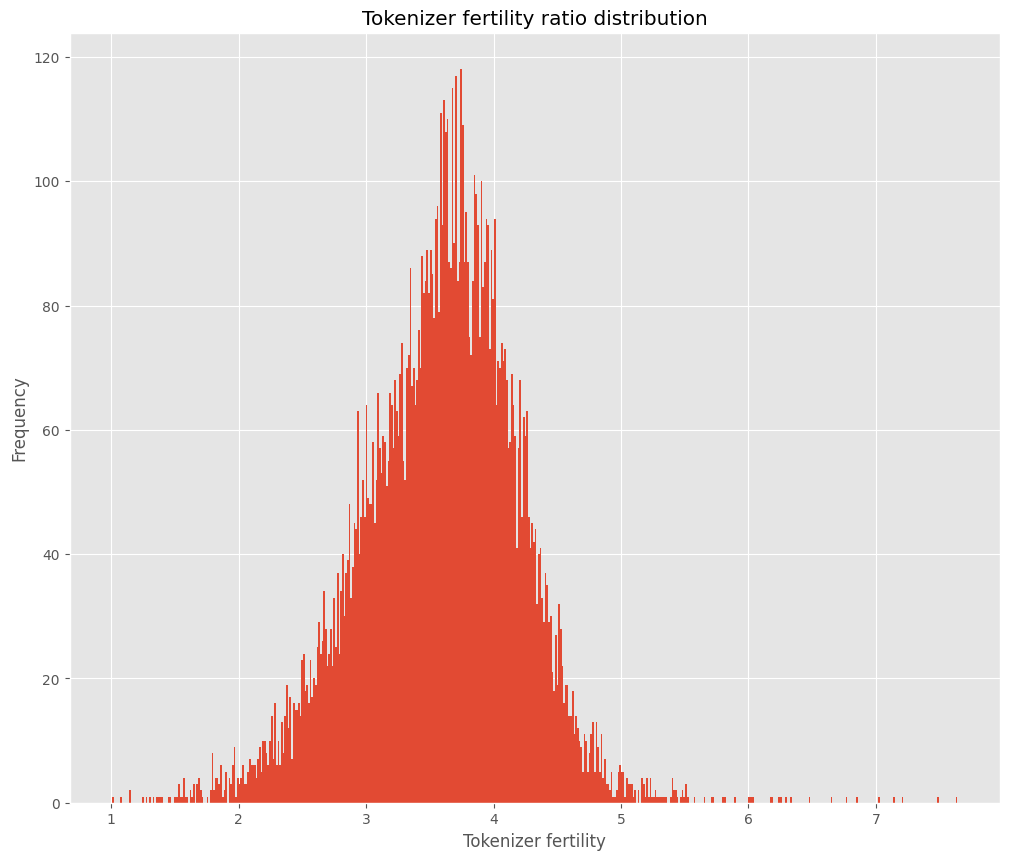

In [11]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
# plot hist of perplexity
plt.hist(ds['fertility_ratio'], bins=500)
plt.title("Tokenizer fertility ratio distribution")
plt.xlabel("Tokenizer fertility")
plt.ylabel("Frequency")
plt.show()

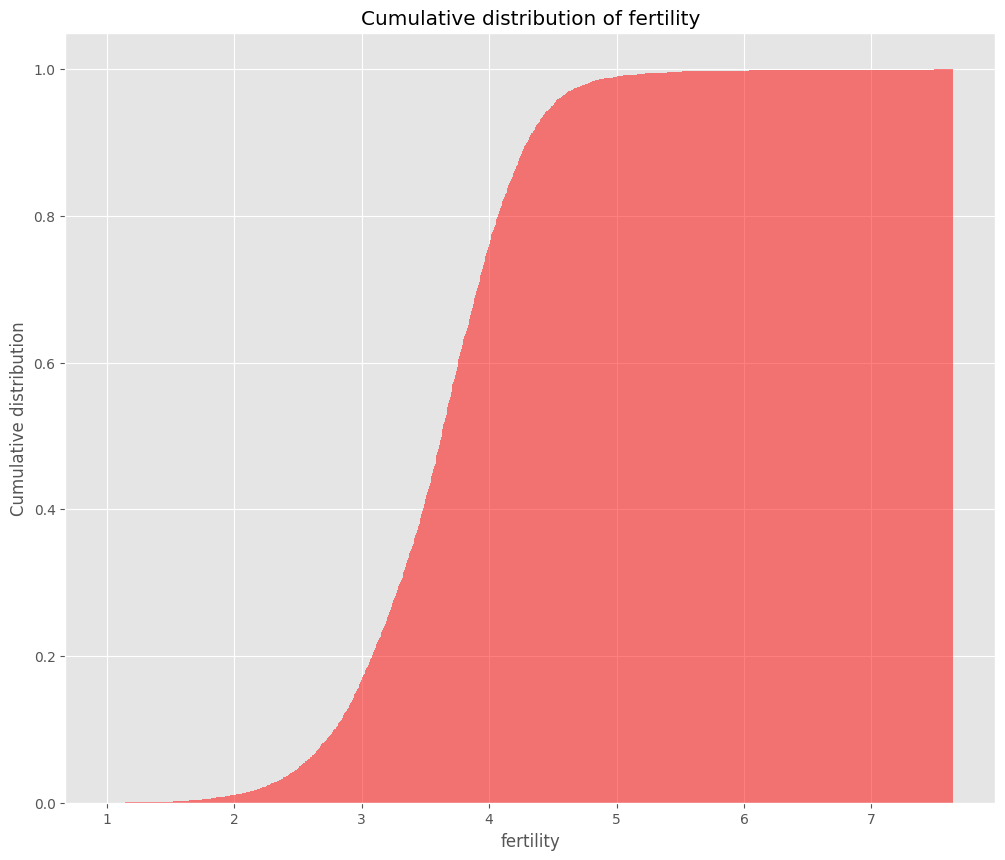

In [12]:
# plot different percentiles from 10 to 99
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
plt.hist(ds['fertility_ratio'], bins=1000, color="#FF0000", alpha=0.5, density=True, cumulative=True)
#plt.xticks(np.arange(0, 2000, 200))
#plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("fertility")
plt.ylabel("Cumulative distribution")
plt.title("Cumulative distribution of fertility")
plt.show()

Let's visualize some samples

In [20]:
print(filtered[2]["content"])

from nose import with_setup

from pygears import Intf, clear
from pygears.typing import Queue, Uint

from utils import svgen_check


@with_setup(clear)
@svgen_check(['sieve_0v2_7_8v10.sv'])
def test_uint():
    iout = Intf(Uint[10])[:2, 7, 8:]
    assert iout.dtype == Uint[5]


@with_setup(clear)
@svgen_check(['sieve_0v2_3_5v7.sv'])
def test_queue():
    iout = Intf(Queue[Uint[2], 6])[:2, 3, 5:]
    assert iout.dtype == Queue[Uint[2], 4]



In [21]:
print(filtered[3]["content"])

import os
import re
import struct
import glob
import numpy as np
import frame_utils
import skimage
import skimage.io

import torch
from torch.utils.data import Dataset


class KLens(Dataset):
    #def __init__(self,raft_path="/data2/opticalflow/rnd/opticalflow/RAFT/out_klens_raft_chairs", root_path="/data2/opticalflow/KLENS/images/",root_path2="/data2/opticalflow/KLENS/pins/",filenumberlist=["0030","1106","1113","1132","1134","1167","1173"],split="train",ref="",meas=""):
    def __init__(self,raft_path="/data2/opticalflow/algo_comp/flownet2/out/", root_path="/data2/opticalflow/KLENS/images/",root_path2="/data2/opticalflow/KLENS/pins/",filenumberlist=["0030","1106","1113","1132","1134","1167","1173"],split="train",ref="",meas=""):
        super(KLens, self).__init__()
        self.split = split
        raftflowpaths = glob.glob(os.path.join(raft_path,"*.flo"))
        file_list = {}
        file_list['train'] = []
        file_list['valid'] = []
        file_list['test'] = []
        fi

In [22]:
print(filtered[4]["content"])

# Copyright 2013-2019 Lawrence Livermore National Security, LLC and other
# Spack Project Developers. See the top-level COPYRIGHT file for details.
#
# SPDX-License-Identifier: (Apache-2.0 OR MIT)

from spack import *


class PyDecorator(PythonPackage):
    """The aim of the decorator module it to simplify the usage of decorators
       for the average programmer, and to popularize decorators by showing
       various non-trivial examples."""

    homepage = "https://github.com/micheles/decorator"
    url      = "https://pypi.io/packages/source/d/decorator/decorator-4.4.0.tar.gz"

    version('4.4.0', sha256='86156361c50488b84a3f148056ea716ca587df2f0de1d34750d35c21312725de')
    version('4.3.0', sha256='c39efa13fbdeb4506c476c9b3babf6a718da943dab7811c206005a4a956c080c')
    version('4.0.9', sha256='90022e83316363788a55352fe39cfbed357aa3a71d90e5f2803a35471de4bba8')

    depends_on('python@2.6:2.8,3.2:', type=('build', 'run'))
    depends_on('py-setuptools', type='build')



In [23]:
print(filtered[5]["content"])

import pyasdf 
import numpy as np 
import scipy.fftpack
import matplotlib.pyplot as plt 

'''
this script takes a chunk of noise spectrum for a station pair and 
compare their cross-correlation functions computed using two schemes:
one is averaging the frequency domain and the other is in the time
domain
'''

def cross_correlation1(fft1,fft2,maxlag,dt,Nfft):
    #------convert all 2D arrays into 1D to speed up--------
    corr = np.zeros(fft1.shape,dtype=np.complex64)
    corr = np.conj(fft1) * fft2

    ncorr = np.zeros((fft1.shape[0],Nfft),dtype=np.complex64)
    ncorr[:,:Nfft//2] = corr[:,:]
    ncorr[:,-(Nfft//2)+1:]=np.flip(np.conj(ncorr[:,1:(Nfft//2)]),axis=1)
    ncorr[:,0]=complex(0,0)
    ncorr = np.real(np.fft.ifftshift(scipy.fftpack.ifft(ncorr, Nfft, axis=1)))

    tcorr = np.arange(-Nfft//2 + 1, Nfft//2)*dt
    ind   = np.where(np.abs(tcorr) <= maxlag)[0]
    ncorr = ncorr[:,ind]
    ncorr = np.mean(ncorr,axis=0)
    return ncorr

def cross_correlation2(fft1,fft2,maxlag,dt,

In [24]:
print(filtered[6]["content"])

import os

LUCKY_SEED = 42
TRAIN_FILE_COUNT = 43
VAL_FILE_COUNT = 12

ROOT_DIR = os.path.abspath(os.path.dirname(__file__))

OBJECTS_DIR = os.path.join(ROOT_DIR, "objects")
OUTPUTS_DIR = os.path.join(ROOT_DIR, "outputs")
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DATA_DIR = os.path.join(ROOT_DIR, "data")

RAW_DATA_DIR = os.path.join(DATA_DIR, "raw_data")
ORIG_DATA_DIR = os.path.join(RAW_DATA_DIR, "sa-emotions")
OTHERS_RAW_DATA = os.path.join(RAW_DATA_DIR, "others")

PROCESSED_DATA_DIR = os.path.join(DATA_DIR, "processed_data")
COMPLEX_PROCESSED_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "complex")
SIMPLE_PROCESSED_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "simple")

TEST_DATA_DIR = os.path.join(DATA_DIR, "testing_data")

TRAIN_DATA_DIR = os.path.join(DATA_DIR, "training_data")
TRAIN_DATA_DIR_WI = os.path.join(TRAIN_DATA_DIR, "word_2_index")
TRAIN_DATA_DIR_TF_IDF = os.path.join(TRAIN_DATA_DIR, "tf_idf")

VAL_DATA_DIR = os.path.join(DATA_DIR, "validation_data")
VAL_DATA_DIR_WI = os.pat

In [50]:
filtered = ds.filter(lambda x: x['fertility_ratio'] < 2.5)
print(f"percentage samples with fertility_ratio < 2.5: {len(filtered)*100/len(ds)}")

Loading cached processed dataset at /Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d41ea51ac33e548d.arrow


percentage samples with fertility_ratio < 2.5: 4.6


In [53]:
# compare volume of filtered and unfiltered dataset
def get_size(examples):
    size_list = []
    for code in examples["content"]:
        size_list.append(len(code))
    return  {"length": size_list}

ds = ds.map(get_size, batch_size=1000, batched=True)
filtered = filtered.map(get_size, batch_size=1000, batched=True)

print(f"percentage of volume removed: {(np.sum(filtered['length'])/np.sum(ds['length']))*100}")

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

percentage of volume removed: 4.560086365426032


In [51]:
filtered

Dataset({
    features: ['content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'licenses', 'repository_name', 'path', 'size', 'lang', 'fertility_ratio'],
    num_rows: 460
})

In [26]:
filtered

Dataset({
    features: ['content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'licenses', 'repository_name', 'path', 'size', 'lang', 'fertility_ratio'],
    num_rows: 617
})

In [36]:
# get data from ds with fertility_ratio < 2.5 and > 2.4
ds2 = ds.filter(lambda x: x['fertility_ratio'] < 2.5 and x['fertility_ratio'] > 2.4)

  0%|          | 0/10 [00:00<?, ?ba/s]

In [37]:
ds2

Dataset({
    features: ['content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'licenses', 'repository_name', 'path', 'size', 'lang', 'fertility_ratio'],
    num_rows: 107
})

In [39]:
print(ds2[0]["content"])

import os
import re
import struct
import glob
import numpy as np
import frame_utils
import skimage
import skimage.io

import torch
from torch.utils.data import Dataset


class KLens(Dataset):
    #def __init__(self,raft_path="/data2/opticalflow/rnd/opticalflow/RAFT/out_klens_raft_chairs", root_path="/data2/opticalflow/KLENS/images/",root_path2="/data2/opticalflow/KLENS/pins/",filenumberlist=["0030","1106","1113","1132","1134","1167","1173"],split="train",ref="",meas=""):
    def __init__(self,raft_path="/data2/opticalflow/algo_comp/flownet2/out/", root_path="/data2/opticalflow/KLENS/images/",root_path2="/data2/opticalflow/KLENS/pins/",filenumberlist=["0030","1106","1113","1132","1134","1167","1173"],split="train",ref="",meas=""):
        super(KLens, self).__init__()
        self.split = split
        raftflowpaths = glob.glob(os.path.join(raft_path,"*.flo"))
        file_list = {}
        file_list['train'] = []
        file_list['valid'] = []
        file_list['test'] = []
        fi

In [40]:
print(ds2[1]["content"])

import pyasdf 
import numpy as np 
import scipy.fftpack
import matplotlib.pyplot as plt 

'''
this script takes a chunk of noise spectrum for a station pair and 
compare their cross-correlation functions computed using two schemes:
one is averaging the frequency domain and the other is in the time
domain
'''

def cross_correlation1(fft1,fft2,maxlag,dt,Nfft):
    #------convert all 2D arrays into 1D to speed up--------
    corr = np.zeros(fft1.shape,dtype=np.complex64)
    corr = np.conj(fft1) * fft2

    ncorr = np.zeros((fft1.shape[0],Nfft),dtype=np.complex64)
    ncorr[:,:Nfft//2] = corr[:,:]
    ncorr[:,-(Nfft//2)+1:]=np.flip(np.conj(ncorr[:,1:(Nfft//2)]),axis=1)
    ncorr[:,0]=complex(0,0)
    ncorr = np.real(np.fft.ifftshift(scipy.fftpack.ifft(ncorr, Nfft, axis=1)))

    tcorr = np.arange(-Nfft//2 + 1, Nfft//2)*dt
    ind   = np.where(np.abs(tcorr) <= maxlag)[0]
    ncorr = ncorr[:,ind]
    ncorr = np.mean(ncorr,axis=0)
    return ncorr

def cross_correlation2(fft1,fft2,maxlag,dt,

In [49]:
print(ds2[12]["content"])

"""
Listas

Listas em Python funcionam como vetores/matrizes (arrays) em outras linguagens, com a diferença
de serem DINÂMICO e também de podermos colocar QUALQUER tipo de dado.

Linguagens C/Java: Arrays
	- Possuem tamanho e tipo de dado fixo;
	Ou seja, nestas linguagens se você criar um array do tipo int e com tamanho 5, este array
	sera SEMPRE do tipo inteiro e poderá ter SEMPRE no máximo 5 valores.

Já em Python:
	- Dinâmico: Não possui tamanho fixo; Ou seja, podemos criar a lista e simplesmente ir adicionando elementos;
	- Qualquer tipo de dado; Não possuem tipo de dado fixo; Ou seja, podemos colocar qualquer tipo de dado;

As listas são mutáveis!

	As listas em Python são representadas por colchetes: []

type([])

lista1 = [1, 99, 4, 27, 15, 22, 3, 1, 44, 42, 27]

lista2 = ['G', 'e', 'e', 'k', ' ', 'U', 'n', 'i', 'v', 'e', 'r', 's', 'i', 't', 'y']

lista3 = []

lista4 = list(range(11))

lista5 = list('Geek University')	

	#  Podemos facilmente checar se determinado valor está con

In [46]:
print(ds2[101]["content"])

import os
from typing import Optional

from pytorchltr.utils.downloader import DefaultDownloadProgress
from pytorchltr.utils.downloader import Downloader
from pytorchltr.utils.file import validate_and_download
from pytorchltr.utils.file import extract_zip
from pytorchltr.utils.file import dataset_dir
from pytorchltr.datasets.svmrank.svmrank import SVMRankDataset


class MSLR10K(SVMRankDataset):
    """
    Utility class for downloading and using the MSLR-WEB10K dataset:
    https://www.microsoft.com/en-us/research/project/mslr/.

    This dataset is a smaller sampled version of the MSLR-WEB30K dataset.
    """

    downloader = Downloader(
        url="https://api.onedrive.com/v1.0/shares/s!AtsMfWUz5l8nbOIoJ6Ks0bEMp78/root/content",  # noqa: E501
        target="MSLR-WEB10K.zip",
        sha256_checksum="2902142ea33f18c59414f654212de5063033b707d5c3939556124b1120d3a0ba",  # noqa: E501
        progress_fn=DefaultDownloadProgress(),
        postprocess_fn=extract_zip)

    per_fold_expect

### Java & JS

In [57]:
# on filtered data
ds = ds_java
ds = ds.map(extract_nl_text, batch_size=1000, batched=True)

# get mean median and percentiles of nl_size
print(f"Mean comment size: {np.mean(ds['fertility_ratio']):.2f}")
print(f"Median comment size: {np.median(ds['fertility_ratio']):.2f}")
print(f"Percentiles of comments size 3rd, 5th, 10th, 20th: {np.round(np.percentile(ds['fertility_ratio'], [3, 5, 10, 20]), 2)}")

Loading cached processed dataset at /Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-95a2b7de57a7cb35/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d0b2580b48b3d9a7.arrow


Mean comment size: 3.95
Median comment size: 3.99
Percentiles of comments size 3rd, 5th, 10th, 20th: [2.75 2.91 3.15 3.47]


In [59]:
filtered = ds.filter(lambda x: x['fertility_ratio'] < 2.8)
print(f"percentage samples with fertility_ratio < 2.8: {len(filtered)*100/len(ds)}")

Loading cached processed dataset at /Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-95a2b7de57a7cb35/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-c8bec82a306f5c2f.arrow


percentage samples with fertility_ratio < 2.8: 3.48


In [67]:
print(filtered[15]["content"])

/*
 * Copyright 2019 Jeff Hain
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */
package net.jolikit.bwd.impl.sdl2;

import java.util.Arrays;

import net.jolikit.bwd.api.events.BwdKeys;
import net.jolikit.bwd.impl.sdl2.jlib.SdlKeycode;
import net.jolikit.bwd.impl.utils.events.AbstractKeyConverter;

/**
 * TODO sdl This converter might not handle all cases, as it only deals with
 * SDL_Keycode values, and SDL might provide keycode values for which there is
 * no SDL_Keycode (for examp

In [65]:
print(filtered[3]["content"])

package estructuradedatos;

import estructuradedatos.BinaryTree;

public class BinaryTree<T> {
	
	private NodoTree<T> raiz;
	private ListG<T> list;
	
	public BinaryTree(){
		this.list =  new ListG<>();
	}
	
	public NodoTree<T> getRaiz() {
		return raiz;
	}

	public void setRaiz(NodoTree<T> raiz) {
		this.raiz = raiz;
	}
	
	public void Insert(T dato){
		NodoTree<T> nodoNuevo = new NodoTree<T>(dato);
		
		if (this.raiz == null)
			this.raiz = nodoNuevo;
		else{
			NodoTree<T> nodoAux = raiz;
			NodoTree<T>  padre;
			while (true){
				padre = nodoAux;
				if (new Integer((int) dato) < new Integer((int) nodoAux.getDato())){
					nodoAux = nodoAux.getIzquierdo();
					if(nodoAux == null){
						padre.setIzquierdo(nodoNuevo);
						return;//Salir del metodo
					}
				}else{
						nodoAux = nodoAux.getDerecho();
						if (nodoAux == null){
							padre.setDerecho(nodoNuevo);
							return;//Salir de metodo
						}
				}
			
			}			
		}		
	}
	
	
	public ListG<T> InOrden(){
		System.out.print

In [64]:
print(filtered[110]["content"])

package com.felix.crazyjava.item1604;

/**
 * Created with IntelliJ IDEA.
 * Description: 创建守护线程
 * Author: Felix
 * Date: 2017/3/8
 * Time: 10:20
 */
public class DaemonThread extends Thread {

    // 定义守护线程的线程执行体与普通线程没有任何区别
    @Override
    public void run() {
        for (int i = 0; i < 1000; i++) {
            System.out.println(getName() + " " + i);
        }
    }

    public static void main(String[] args) throws Exception {
        DaemonThread dt = new DaemonThread();
        // 将此线程设置成守护线程，该语句必须在线程启动之前
        dt.setDaemon(true);
        // 启动线程
        dt.start();
        // Thread.sleep(1);
        for (int i = 0; i < 10; i++) {
            System.out.println(Thread.currentThread().getName() + " " + i);
        }
        // 程序执行到此处，前台线程（main线程）结束
        // 守护线程也应该随之结束
    }
}



In [68]:
# on filtered data
ds = ds_js
ds = ds.map(extract_nl_text, batch_size=1000, batched=True)

# get mean median and percentiles of nl_size
print(f"Mean comment size: {np.mean(ds['fertility_ratio']):.2f}")
print(f"Median comment size: {np.median(ds['fertility_ratio']):.2f}")
print(f"Percentiles of comments size 3rd, 5th, 10th, 20th: {np.round(np.percentile(ds['fertility_ratio'], [3, 5, 10, 20]), 2)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

Mean comment size: 3.49
Median comment size: 3.56
Percentiles of comments size 3rd, 5th, 10th, 20th: [1.8  2.03 2.46 2.92]


In [69]:
filtered = ds.filter(lambda x: x['fertility_ratio'] < 2)
print(f"percentage samples with fertility_ratio < 2: {len(filtered)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with fertility_ratio < 2: 4.62


In [70]:
print(filtered[0]["content"])

import React from 'react';
import createSvgIcon from './utils/createSvgIcon';

export default createSvgIcon(
  <path d="M17 5V3H7v2H3v3c0 2.55 1.92 4.63 4.39 4.94.63 1.5 1.98 2.63 3.61 2.96V19H7v2h10v-2h-4v-3.1c1.63-.33 2.98-1.46 3.61-2.96C19.08 12.63 21 10.55 21 8V5h-4zM7 10.82C5.84 10.4 5 9.3 5 8V7h2v3.82zM19 8c0 1.3-.84 2.4-2 2.82V7h2v1z" />
, 'EmojiEventsSharp');



In [71]:
print(filtered[1]["content"])

/*! jQuery Validation Plugin - v1.14.0 - 6/30/2015
 * http://jqueryvalidation.org/
 * Copyright (c) 2015 Jörn Zaefferer; Licensed MIT */
!function(a){"function"==typeof define&&define.amd?define(["jquery","./jquery.validate.min"],a):a(jQuery)}(function(a){!function(){function b(a){return a.replace(/<.[^<>]*?>/g," ").replace(/&nbsp;|&#160;/gi," ").replace(/[.(),;:!?%#$'\"_+=\/\-“”’]*/g,"")}a.validator.addMethod("maxWords",function(a,c,d){return this.optional(c)||b(a).match(/\b\w+\b/g).length<=d},a.validator.format("Please enter {0} words or less.")),a.validator.addMethod("minWords",function(a,c,d){return this.optional(c)||b(a).match(/\b\w+\b/g).length>=d},a.validator.format("Please enter at least {0} words.")),a.validator.addMethod("rangeWords",function(a,c,d){var e=b(a),f=/\b\w+\b/g;return this.optional(c)||e.match(f).length>=d[0]&&e.match(f).length<=d[1]},a.validator.format("Please enter between {0} and {1} words."))}(),a.validator.addMethod("accept",function(b,c,d){var e,f,g="string"

These seem like files to be filtered by line length, we'll run thsi analysis on JS data after filtering later

In [72]:
print(filtered[1]["content"])

/*! jQuery Validation Plugin - v1.14.0 - 6/30/2015
 * http://jqueryvalidation.org/
 * Copyright (c) 2015 Jörn Zaefferer; Licensed MIT */
!function(a){"function"==typeof define&&define.amd?define(["jquery","./jquery.validate.min"],a):a(jQuery)}(function(a){!function(){function b(a){return a.replace(/<.[^<>]*?>/g," ").replace(/&nbsp;|&#160;/gi," ").replace(/[.(),;:!?%#$'\"_+=\/\-“”’]*/g,"")}a.validator.addMethod("maxWords",function(a,c,d){return this.optional(c)||b(a).match(/\b\w+\b/g).length<=d},a.validator.format("Please enter {0} words or less.")),a.validator.addMethod("minWords",function(a,c,d){return this.optional(c)||b(a).match(/\b\w+\b/g).length>=d},a.validator.format("Please enter at least {0} words.")),a.validator.addMethod("rangeWords",function(a,c,d){var e=b(a),f=/\b\w+\b/g;return this.optional(c)||e.match(f).length>=d[0]&&e.match(f).length<=d[1]},a.validator.format("Please enter between {0} and {1} words."))}(),a.validator.addMethod("accept",function(b,c,d){var e,f,g="string"

In [73]:
print(filtered[3]["content"])

'use strict';

var _20 = {
  elem: 'svg',
  attrs: {
    xmlns: 'http://www.w3.org/2000/svg',
    viewBox: '0 0 32 32',
    width: 20,
    height: 20,
  },
  content: [
    {
      elem: 'path',
      attrs: {
        d:
          'M2 16A14 14 0 1 0 16 2 14 14 0 0 0 2 16zm23.15 7.75L8.25 6.85a12 12 0 0 1 16.9 16.9zM8.24 25.16a12 12 0 0 1-1.4-16.89l16.89 16.89a12 12 0 0 1-15.49 0z',
      },
    },
  ],
  name: 'error',
  size: 20,
};

module.exports = _20;



In [75]:
print(filtered[4]["content"])

webpackJsonp([62,141],{775:function(t,e){t.exports={content:["section",["p","\u4f4d\u4e8e APP \u5e95\u90e8\uff0c\u65b9\u4fbf\u7528\u6237\u5728\u4e0d\u540c\u529f\u80fd\u6a21\u5757\u4e4b\u95f4\u8fdb\u884c\u5feb\u901f\u5207\u6362\u3002"],["h3","\u89c4\u5219"],["ul",["li",["p","\u7528\u4f5c APP \u7684\u4e00\u7ea7\u5206\u7c7b\uff0c\u6570\u91cf\u63a7\u5236\u5728 3-5 \u4e2a\u4e4b\u95f4\u3002"]],["li",["p","\u5373\u4f7f\u67d0\u4e2a Tab \u4e0d\u53ef\u7528\uff0c\u4e5f\u4e0d\u8981\u7981\u7528\u6216\u8005\u79fb\u9664\u8be5 Tab\u3002"]],["li",["p","\u4f7f\u7528 Badge \u8fdb\u884c\u63d0\u793a\uff0c\u8db3\u4e0d\u51fa\u6237\u4e5f\u80fd\u77e5\u9053\u6709\u5185\u5bb9\u66f4\u65b0\u3002"]]]],meta:{category:"Components",type:"Navigation",title:"TabBar",filename:"components/tab-bar/index.en-US.md"},api:["section",["h2","API"],["p","Support WEB, React-Native."],["h3","TabBar"],["table",["thead",["tr",["th","Properties"],["th","Descrition"],["th","Type"],["th","Default"]]],["tbody",["tr",["td","barTintColor"]

In [76]:
filtered = ds.filter(lambda x: x['fertility_ratio'] < 2.3)
print(f"percentage samples with fertility_ratio < 2: {len(filtered)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with fertility_ratio < 2: 7.83


In [77]:
filtered = ds.filter(lambda x: x['fertility_ratio'] < 2.5 and x['fertility_ratio'] > 2.3)
print(f"percentage samples with fertility_ratio < 2: {len(filtered)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with fertility_ratio < 2: 2.88


In [78]:
print(filtered[0]["content"])

define({
  "visible": "显示默认的总览图",
  "minWidth": "最小宽度",
  "minHeight": "最小高度",
  "maxWidth": "最大宽度",
  "maxHeight": "最大高度",
  "minText": "最小值",
  "maxText": "最大值",
  "attachText": "指定要在地图的哪个地方附加此微件。",
  "expandText": "初始展开微件",
  "topLeft": "左上",
  "topRight": "右上",
  "bottomLeft": "左下",
  "bottomRight": "右下",
  "baseLayerType": "显示",
  "BaseMap": "地图的底图",
  "ArcGIS": "ArcGIS",
  "tiledMapService": "ArcGIS 切片地图服务",
  "dynamicMapService": "ArcGIS 动态地图服务",
  "imageService": "ArcGIS 影像服务",
  "OSM": "开放街道地图",
  "bingRoad": "Bing 道路地图",
  "bingAerial": "Bing 影像地图",
  "bingHybrid": "Bing 混合地图",
  "WebTiled": "Web 切片图层",
  "VETiled": "Virtual Earth 切片图层",
  "tileLayerUrl": "切片图层 Url",
  "tile": "标题",
  "credits": "制作者名单",
  "subdomain": "子域",
  "extent": "范围",
  "initExtent": "初始范围",
  "tileInfo": "TileInfo",
  "VEStyle": "Virtual Earth 风格",
  "Aerial": "Bing 航空地图图层",
  "AerialWithLabels": "具有标注的航空图图层",
  "Roads": "道路图层",
  "errWkid": "wkid 不匹配",
  "errUrl": "URL 无效",
  "errReqTimeout": "超时",


In [79]:
print(filtered[1]["content"])

import React from 'react';
import {
  StyleSheet,
  Text,
  View,
  Dimensions,
  ScrollView,
  TouchableOpacity,
  Image,
  Alert,
  StatusBar,
  Platform,
} from 'react-native';
import Modal from 'react-native-modal';
import SearchableDropdown from 'react-native-searchable-dropdown';
import ImageViewer from 'react-native-image-zoom-viewer';
const { width } = Dimensions.get('window');
//Item array for the dropdown
var itemsDiurno = [
  //name key is must.It is to show the text in front
  { id: 71, name: 'L001 - Presidente Vargas-Diamantino', key: 'LinhaDiurno71'},
  { id: 72, name: 'L002 - Serrano', key: 'LinhaDiurno72'},
  { id: 41, name: 'L003 - Petrópolis-Treviso-BR 116', key: 'LinhaDiurno41'},
  { id: 26, name: 'L004 - Industrial-Santo Antonio-Vila Ipê-Colinado Sol-Belo Horizonte-Rota do Sol', key: 'LinhaDiurno26'},
  { id: 49, name: 'L005 - São Gotardo-Santa Bárbara-Loteamento Bachi-Vila Alpina', key: 'LinhaDiurno49'},
  { id: 62, name: 'L006 - Serrano', key: 'LinhaDiurno62'},
 

In [80]:
print(filtered[10]["content"])

"use strict";(self.webpackChunkrorscharg_blog=self.webpackChunkrorscharg_blog||[]).push([[7855],{7855:function(e,o,c){c.r(o),c.d(o,{theme:function(){return g}});var g="{\n  --deckgo-highlight-code-carbon-background: #0c1021;\n  --deckgo-highlight-code-carbon-color: #f8f8f8;\n  --deckgo-highlight-code-token-atrule: #fbde2d;\n  --deckgo-highlight-code-token-comment: #aeaeae;\n  --deckgo-highlight-code-token-comment-rgb: 174, 174, 174;\n  --deckgo-highlight-code-token-function: #ff6400;\n  --deckgo-highlight-code-token-operator: #ffffff;\n  --deckgo-highlight-code-token-property: #ffffff;\n  --deckgo-highlight-code-token-punctuation: #ffffff;\n  --deckgo-highlight-code-token-regex: #61ce3c;\n  --deckgo-highlight-code-token-selector: #8da6ce;\n}"}}]);
//# sourceMappingURL=7855-8cf5bdd5cc3c0977dd26.js.map


In [81]:
print(filtered[100]["content"])

"use strict";
var ctx = document.querySelector("#canvas").getContext("2d");
var angle = 0.75; // Угол разворота ветвей
var r = Math.floor(Math.random() * Math.floor(255));
var g = Math.floor(Math.random() * Math.floor(255));
var b = Math.floor(Math.random() * Math.floor(255));

function tree(length, angle, scale) {
    ctx.fillStyle = "rgb(" + r + "," + g + "," + b + ")";
    ctx.fillRect(0, 0, 1, length); // Рисуем "ствол-корень" дерева

    var min_length = 8;

    // Обрываем рекурсию, когда линии становятся слишком короткими 
    if (length < min_length) {
        return;
    }

    ctx.save(); // Сохраняем текущее состояние системы координат
    ctx.translate(0, length); // Сдвигаем "курсор" в конец "ствола-корня"
    ctx.rotate(angle); // Поворачиваем систему координат на какой-то угол влево
    tree(length * scale, -angle, scale); // Рекурсивно рисуем левую ветвь
    ctx.rotate(2 * -angle); // Поворачиваем систему координат на симметричный угол вправо
    tree(length * scale, an

In [82]:
print(filtered[15]["content"])

/**
 * Bootstrap Table Georgian translation
 * Author: Levan Lotuashvili <l.lotuashvili@gmail.com>
 */
(function () {
    'use strict';

    BootstrapTable.locales['ka-GE'] = {
        formatLoadingMessage: function() {
            return 'იტვირთება, გთხოვთ მოიცადოთ...';
        },
        formatRecordsPerPage: function(pageNumber) {
            return pageNumber + ' ჩანაწერი თითო გვერდზე';
        },
        formatShowingRows: function(pageFrom, pageTo, totalRows) {
            return 'ნაჩვენებია ' + pageFrom + '-დან ' + pageTo + '-მდე ჩანაწერი ჯამური ' + totalRows + '-დან';
        },
        formatSearch: function() {
            return 'ძებნა';
        },
        formatNoMatches: function() {
            return 'მონაცემები არ არის';
        },
        formatPaginationSwitch: function() {
            return 'გვერდების გადამრთველის დამალვა/გამოჩენა';
        },
        formatRefresh: function() {
            return 'განახლება';
        },
        formatToggle: function() {
          

In [83]:
print(filtered[34]["content"])

(self.webpackChunk=self.webpackChunk||[]).push([[355],{6937:(e,t,r)=>{"use strict";r.d(t,{Z:()=>E});var n=r(5893),o=r(7294),a=r(3727),s=r(2122),c=r(9756),i=r(5697),l=r.n(i),u=r(4184),d=r.n(u),p=r(3663),f={tag:p.iC,active:l().bool,className:l().string,cssModule:l().object},h=function(e){var t=e.className,r=e.cssModule,n=e.active,a=e.tag,i=(0,c.Z)(e,["className","cssModule","active","tag"]),l=(0,p.mx)(d()(t,!!n&&"active","breadcrumb-item"),r);return o.createElement(a,(0,s.Z)({},i,{className:l,"aria-current":n?"page":void 0}))};h.propTypes=f,h.defaultProps={tag:"li"};const b=h;var m={tag:p.iC,listTag:p.iC,className:l().string,listClassName:l().string,cssModule:l().object,children:l().node,"aria-label":l().string},g=function(e){var t=e.className,r=e.listClassName,n=e.cssModule,a=e.children,i=e.tag,l=e.listTag,u=e["aria-label"],f=(0,c.Z)(e,["className","listClassName","cssModule","children","tag","listTag","aria-label"]),h=(0,p.mx)(d()(t),n),b=(0,p.mx)(d()("breadcrumb",r),n);return o.create

In [84]:
# after filtering ds_js
# on filtered data
ds = ds_js_filter
ds = ds.map(extract_nl_text, batch_size=1000, batched=True)

# get mean median and percentiles of nl_size
print(f"Mean comment size: {np.mean(ds['fertility_ratio']):.2f}")
print(f"Median comment size: {np.median(ds['fertility_ratio']):.2f}")
print(f"Percentiles of comments size 3rd, 5th, 10th, 20th: {np.round(np.percentile(ds['fertility_ratio'], [3, 5, 10, 20]), 2)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

Mean comment size: 3.57
Median comment size: 3.60
Percentiles of comments size 3rd, 5th, 10th, 20th: [2.06 2.37 2.75 3.09]


In [85]:
filtered = ds.filter(lambda x: x['fertility_ratio'] < 2.4)
print(f"percentage samples with fertility_ratio < 2.4: {len(filtered)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with fertility_ratio < 2.4: 5.31


In [86]:
print(filtered[0]["content"])

"use strict";
Object.defineProperty(exports, "__esModule", { value: true });
const React = require("react");
const wrapIcon_1 = require("../utils/wrapIcon");
const rawSvg = (iconProps) => {
    const { className, primaryFill } = iconProps;
    return React.createElement("svg", { width: 24, height: 24, viewBox: "0 0 24 24", xmlns: "http://www.w3.org/2000/svg", className: className },
        React.createElement("path", { d: "M10.96 16.44a1.5 1.5 0 112.12 2.12 1.5 1.5 0 01-2.12-2.12zm-2.6-2.74a5.23 5.23 0 018.5 1.62 1 1 0 11-1.83.8 3.23 3.23 0 00-5.93-.01 1 1 0 11-1.83-.8c.26-.6.63-1.15 1.09-1.61zm-2.05-3a8.13 8.13 0 0113 2.1 1 1 0 01-1.78.9 6.13 6.13 0 00-10.94-.02 1 1 0 11-1.78-.9c.38-.76.88-1.46 1.5-2.07z", fill: primaryFill }));
};
const Wifi224Filled = wrapIcon_1.default(rawSvg({}), 'Wifi224Filled');
exports.default = Wifi224Filled;



In [87]:
print(filtered[1]["content"])

self.__precacheManifest = (self.__precacheManifest || []).concat([
  {
    "revision": "vqbpgud2ghvjgm1n5hdgjnn5818fzsf2",
    "url": "/index.html"
  },
  {
    "revision": "vqbpgud2ghvjgm1n5hdgjnn5818fzsf2",
    "url": "/static/css/main.28ec31e2.chunk.css"
  },
  {
    "revision": "8f77005c9e943d456dda",
    "url": "/static/js/2.dbdf6981.chunk.js"
  },
  {
    "revision": "603816eec26c1aff4a38bef8d08d40a6",
    "url": "/static/js/2.dbdf6981.chunk.js.LICENSE.txt"
  },
  {
    "revision": "vqbpgud2ghvjgm1n5hdgjnn5818fzsf2",
    "url": "/static/js/main.6d9023c5.chunk.js"
  },
  {
    "revision": "9b4e396c183e42c1fa5c",
    "url": "/static/js/runtime-main.09b85ec0.js"
  },
  {
    "revision": "4b31330b20e3cff3e49d540e4e7175e2",
    "url": "/static/media/showcase.4b31330b.jpg"
  }
]);


In [88]:
print(filtered[2]["content"])

'use strict';

var React = require('react');
var PureRenderMixin = require('react-addons-pure-render-mixin');
var SvgIcon = require('../../svg-icon');

var ActionAccountBox = React.createClass({
  displayName: 'ActionAccountBox',

  mixins: [PureRenderMixin],

  render: function render() {
    return React.createElement(
      SvgIcon,
      this.props,
      React.createElement('path', { d: 'M3 5v14c0 1.1.89 2 2 2h14c1.1 0 2-.9 2-2V5c0-1.1-.9-2-2-2H5c-1.11 0-2 .9-2 2zm12 4c0 1.66-1.34 3-3 3s-3-1.34-3-3 1.34-3 3-3 3 1.34 3 3zm-9 8c0-2 4-3.1 6-3.1s6 1.1 6 3.1v1H6v-1z' })
    );
  }

});

module.exports = ActionAccountBox;


In [90]:
# get data from ds with fertility_ratio < 2.5 and > 2.4
ds2 = ds.filter(lambda x: x['fertility_ratio'] < 2.8  and x['fertility_ratio'] > 2.5)
print(f"percentage samples with fertility_ratio < 3: {len(ds2)*100/len(ds)}")

  0%|          | 0/10 [00:00<?, ?ba/s]

percentage samples with fertility_ratio < 3: 4.84


In [93]:
print(ds2[3]["content"])

'use strict';

module.exports = [
	{
		name: 'hover',
		retry: 1,
		timeout: 30000,
		specs: [
			{
				name: 'hovers link',
				time: 1000,
				body: () => {
					navigate('/test.html');
					hover(text('Link'));
					is(text('Hovered'));
				}
			},
			{
				skip: !global.chai,
				name: 'fails without target',
				time: 1000,
				body: () => {
					navigate('/other.html');
					now(
						() => expect(
							now.hover(text('Nothing'))
						).to.be.eventually.rejectedWith(Error)
					);
				}
			}
		]
	}
];



In [94]:
print(ds2[4]["content"])

let x = 23
let oX = new Number(23)

console.log(typeof x)
console.log(typeof oX)
console.log(oX *2)

'22' * 2
// Number('22') * 2

let name = 'Pepe'
let aDatos = []


// Importado de elementales.ts
function numbers() {
    let num = 23
    console.log(num)
    console.log(num.toFixed(2))
    let numPrecision = num.toFixed(2)
    console.log(typeof numPrecision)
    console.log(typeof num)
}
numbers()
